# Local authority methodology

## Introduction

When policy changes in the UK - taxes, benefits, or public spending - it affects places and people differently. PolicyEngine UK builds tools to analyze incomes, jobs, and population patterns in each local authoirity district. This documentation explains how we create a microsimulation model that works at the local authoirity level. The system combines workplace surveys of jobs and earnings, HMRC tax records, and population statistics. We estimate income distributions, and optimize geographic weights.

This guide shows how to use PolicyEngine UK for local authoirity analysis. We start with data collection, transform it for modeling, and build tools to examine policies. The guide provides examples and code to implement these methods. Users can measure changes in household budgets, track employment, and understand economic patterns on different local authoirity districts. This document starts with data collection from workplace surveys, tax records, and population counts, then explains how we convert this data into usable forms through income brackets. It concludes with technical details about accuracy measurement and calibration, plus example code for analysis and visualization.

## Data

In this section, we describe three main data sources that form the foundation of our local authority level analysis: earning and jobs data from NOMIS ASHE, income statistics from HMRC, and population age distributions from the House of Commons Library.

### Earning and jobs data

Data is extracted from NOMIS Annual Survey of Hours and Earnings (ASHE) - workplace analysis dataset, containing number of jobs and earnings percentiles for all UK local authority districts from the [NOMIS website](https://www.nomisweb.co.uk/datasets/ashe). This dataset is stored as [`nomis_earning_jobs_data.xlsx`](https://github.com/PolicyEngine/policyengine-uk-data/blob/7c782c4839a024c729350a3ff2c76922bf21b0d4/policyengine_uk_data/datasets/frs/local_areas/local_authorities/targets/nomis_earning_jobs_data.xlsx). To download the data, follow the variable selection process shown in the image below:

![](pictures/nomis_screenshot2.png)

### Income data

Income data for UK local authorities is obtained from [HMRC](https://www.gov.uk/government/statistics/income-and-tax-by-borough-and-district-or-unitary-authority-confidence-intervals). This dataset provides detailed information about income and tax by local authorities with confidence intervals, and is stored as [`total_income.csv`](https://github.com/PolicyEngine/policyengine-uk-data/blob/7c782c4839a024c729350a3ff2c76922bf21b0d4/policyengine_uk_data/datasets/frs/local_areas/local_authorities/targets/total_income.csv), including two key variables:

- [`total_income_count`](https://github.com/PolicyEngine/policyengine-uk-data/blob/7c782c4839a024c729350a3ff2c76922bf21b0d4/policyengine_uk_data/datasets/frs/local_areas/local_authorities/targets/total_income.csv#L1): the total number of taxpayers in each local authority

- [`total_income_amount`](https://github.com/PolicyEngine/policyengine-uk-data/blob/7c782c4839a024c729350a3ff2c76922bf21b0d4/policyengine_uk_data/datasets/frs/local_areas/local_authorities/targets/total_income.csv#L1): the total amount of income for all taxpayers in each local authority

We use these measures to identify similar local authorities when employment distribution data is missing. Our approach assumes that local authorities with similar income patterns (measured by both taxpayer counts and total income) will have similar earnings distributions. The following table shows the dataset:


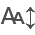

code                     name  total_income_count  \
0    E06000001            Hartlepool UA             41000.0   
1    E06000002         Middlesbrough UA             60000.0   
2    E06000003  Redcar and Cleveland UA             65000.0   
3    E06000004      Stockton-on-Tees UA             91000.0   
4    E06000005            Darlington UA             52000.0   
..         ...                      ...                 ...   
355  W06000020                  Torfaen             43000.0   
356  W06000021            Monmouthshire             51000.0   
357  W06000022                  Newport             72000.0   
358  W06000023                    Powys             65000.0   
359  W06000024           Merthyr Tydfil             25000.0   

     total_income_amount  
0           1.258700e+09  
1           1.812000e+09  
2           1.885000e+09  
3           3.039400e+09  
4           1.653600e+09  
..                   ...  
355         1.238400e+09  
356         1.953300e+09  
357         2.253600e+09  
358         1.995500e+09  
359         7.100000e+08  

[360 rows x 4 columns]

In [1]:
import pandas as pd
from itables import init_notebook_mode, show
import itables.options as opt
opt.maxBytes = "1MB"
init_notebook_mode(all_interactive=True)

pd.read_csv("../policyengine_uk_data/datasets/frs/local_areas/local_authorities/targets/total_income.csv")

### Population data by age

Population data by age groups for UK local authorities can be downloaded from the [ONS data dashboard](https://www.nomisweb.co.uk/datasets/pestsyoala). The dataset provides detailed age breakdowns for each UK local authority, containing population counts for every age from 0 to 90+ years old across all local authorities in England, Wales, Northern Ireland, and Scotland. The data is stored as [`age.csv`](https://github.com/PolicyEngine/policyengine-uk-data/blob/7c782c4839a024c729350a3ff2c76922bf21b0d4/policyengine_uk_data/datasets/frs/local_areas/local_authorities/targets/age.csv). The following table shows the dataset:


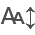

code                  name       all       0       1       2  \
0    E06000001            Hartlepool   95366.0   915.0   960.0   981.0   
1    E06000002         Middlesbrough  152650.0  1824.0  1798.0  1766.0   
2    E06000003  Redcar and Cleveland  137938.0  1259.0  1359.0  1226.0   
3    E06000004      Stockton-on-Tees  202415.0  1924.0  2078.0  2032.0   
4    E06000005            Darlington  110562.0  1010.0  1115.0  1102.0   
..         ...                   ...       ...     ...     ...     ...   
355  W06000020               Torfaen   93419.0   928.0   975.0   934.0   
356  W06000021         Monmouthshire   94572.0   738.0   796.0   830.0   
357  W06000022               Newport  163628.0  1835.0  1984.0  1934.0   
358  W06000023                 Powys  134439.0   952.0  1094.0  1083.0   
359  W06000024        Merthyr Tydfil   58593.0   573.0   607.0   616.0   

          3       4       5       6  ...      81     82     83     84     85  \
0    1066.0  1081.0  1069.0  1152.0  ...   500.0  442.0  465.0  407.0  429.0   
1    1830.0  1889.0  1940.0  2081.0  ...   722.0  580.0  574.0  557.0  520.0   
2    1367.0  1416.0  1419.0  1535.0  ...   992.0  851.0  854.0  828.0  685.0   
3    2203.0  2266.0  2282.0  2451.0  ...  1133.0  993.0  941.0  885.0  819.0   
4    1157.0  1168.0  1210.0  1152.0  ...   633.0  592.0  613.0  554.0  503.0   
..      ...     ...     ...     ...  ...     ...    ...    ...    ...    ...   
355  1027.0  1037.0  1048.0  1061.0  ...   611.0  545.0  461.0  451.0  412.0   
356   828.0   828.0   878.0   917.0  ...   807.0  657.0  666.0  571.0  524.0   
357  2011.0  2095.0  2054.0  2104.0  ...   858.0  734.0  689.0  658.0  554.0   
358  1138.0  1206.0  1261.0  1264.0  ...  1164.0  979.0  982.0  878.0  808.0   
359   649.0   679.0   685.0   738.0  ...   323.0  265.0  268.0  227.0  235.0   

        86     87     88     89     90+  
0    382.0  266.0  300.0  206.0   828.0  
1    457.0  424.0  341.0  301.0  1120.0  
2    637.0  546.0  456.0  370.0  1314.0  
3    693.0  568.0  535.0  390.0  1570.0  
4    448.0  377.0  354.0  277.0  1083.0  
..     ...    ...    ...    ...     ...  
355  341.0  349.0  285.0  252.0   813.0  
356  477.0  442.0  379.0  322.0  1287.0  
357  536.0  472.0  364.0  321.0  1282.0  
358  735.0  616.0  530.0  455.0  1761.0  
359  199.0  158.0  147.0  114.0   412.0  

[360 rows x 94 columns]

In [2]:
import pandas as pd
from itables import init_notebook_mode, show
import itables.options as opt
opt.maxBytes = "1MB"
init_notebook_mode(all_interactive=True)

pd.read_csv("../policyengine_uk_data/datasets/frs/local_areas/local_authorities/targets/age.csv")

## Preprocessing

In this section, we detail a preprocessing step necessary for our local authority level analysis: converting earnings percentiles into practical income brackets. 

### Convert earning percentiles to brackets

To analyze earnings data effectively, we convert earning percentiles into earning brackets through the following process:

1. First, we estimate the full distribution of earnings by:
    - Using known percentile data (10th to 90th) from the ASHE dataset
    - Extending this to estimate the 90th-99th percentiles using ratios derived from [this government statistics report](https://www.gov.uk/government/statistics/percentile-points-from-1-to-99-for-total-income-before-and-after-tax#:~:text=Details,in%20the%20Background%20Quality%20Report)

2. This estimation allows us to map earnings data into brackets that align with policy thresholds.

After estimating the full earnings distribution, we convert the data into income brackets. We calculate the number of jobs and total earnings for each local authority and income bracket based on the estimated earnings distribution. When we encounter local authorities with missing data, we estimate their earnings distribution pattern using data from local authorities with similar total number of taxpayers and total income levels. 

The script [`create_employment_incomes.py`](https://github.com/PolicyEngine/policyengine-uk-data/blob/7c782c4839a024c729350a3ff2c76922bf21b0d4/policyengine_uk_data/datasets/frs/local_areas/local_authorities/targets/create_employment_incomes.py) generates [`employment_income.csv`](https://github.com/PolicyEngine/policyengine-uk-data/blob/7c782c4839a024c729350a3ff2c76922bf21b0d4/policyengine_uk_data/datasets/frs/local_areas/local_authorities/targets/employment_income.csv) containing number of jobs ([`employment_income_count`](https://github.com/PolicyEngine/policyengine-uk-data/blob/7c782c4839a024c729350a3ff2c76922bf21b0d4/policyengine_uk_data/datasets/frs/local_areas/local_authorities/targets/employment_income.csv#L1)) and total earnings ([`employment_income_amount`](https://github.com/PolicyEngine/policyengine-uk-data/blob/7c782c4839a024c729350a3ff2c76922bf21b0d4/policyengine_uk_data/datasets/frs/local_areas/local_authorities/targets/employment_income.csv#L1)) for each local authority and income bracket. The following table shows employment and income across different brackets for local authorities:


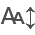

code            name  employment_income_lower_bound  \
0     E06000001      Hartlepool                              0   
1     E06000001      Hartlepool                          50000   
2     E06000001      Hartlepool                          12570   
3     E06000001      Hartlepool                          15000   
4     E06000001      Hartlepool                          30000   
...         ...             ...                            ...   
4675  W06000024  Merthyr Tydfil                         200000   
4676  W06000024  Merthyr Tydfil                         300000   
4677  W06000024  Merthyr Tydfil                          50000   
4678  W06000024  Merthyr Tydfil                          20000   
4679  W06000024  Merthyr Tydfil                         500000   

      employment_income_upper_bound  employment_income_count  \
0                           12570.0               758.154411   
1                           70000.0              4042.906639   
2                           15000.0               405.049313   
3                           20000.0              1609.951463   
4                           40000.0              5209.259896   
...                             ...                      ...   
4675                       300000.0                74.985344   
4676                       500000.0                 0.000000   
4677                        70000.0              4111.661887   
4678                        30000.0              5329.828771   
4679                            inf                 0.000000   

      employment_income_amount  
0                 4.765000e+06  
1                 2.425744e+08  
2                 5.583605e+06  
3                 2.817415e+07  
4                 1.823241e+08  
...                        ...  
4675              1.874634e+07  
4676              0.000000e+00  
4677              2.466997e+08  
4678              1.332457e+08  
4679              0.000000e+00  

[4680 rows x 6 columns]

In [3]:
import pandas as pd
from itables import init_notebook_mode, show
import itables.options as opt
opt.maxBytes = "1MB"
init_notebook_mode(all_interactive=True)

pd.read_csv("../policyengine_uk_data/datasets/frs/local_areas/local_authorities/targets/employment_income.csv")

## Methodology

This section describes our approach to creating accurate local authority level estimates through three key components: a loss function for evaluating accuracy, a calibration process for optimizing weights, and the mathematical framework behind the optimization. To see how well this methodology performs in practice, you can check our detailed [validation results page](https://github.com/PolicyEngine/policyengine-uk-data/blob/7c782c4839a024c729350a3ff2c76922bf21b0d4/docs/validation/local_authorities.ipynb) comparing our estimates against actual data at both local authority and national levels.

### Loss function

The file [`loss.py`](https://github.com/PolicyEngine/policyengine-uk-data/blob/7c782c4839a024c729350a3ff2c76922bf21b0d4/policyengine_uk_data/datasets/frs/local_areas/local_authorities/loss.py) defines a function [`create_local_authority_target_matrix`](https://github.com/PolicyEngine/policyengine-uk-data/blob/7c782c4839a024c729350a3ff2c76922bf21b0d4/policyengine_uk_data/datasets/frs/local_areas/local_authorities/loss.py#L8) that creates target matrices for comparing simulated data against actual local authority level data. The following process outlines how the function processes:

1. Takes three main input parameters: dataset (defaults to [`enhanced_frs_2022_23`](https://github.com/PolicyEngine/policyengine-uk-data/blob/7c782c4839a024c729350a3ff2c76922bf21b0d4/policyengine_uk_data/datasets/frs/local_areas/local_authorities/loss.py#L15)), time_period (defaults to 2025), and an optional reform parameter for policy changes.

2. Reads three files containing real data: [`age.csv`](https://github.com/PolicyEngine/policyengine-uk-data/blob/7c782c4839a024c729350a3ff2c76922bf21b0d4/policyengine_uk_data/datasets/frs/local_areas/local_authorities/targets/age.csv), [`total_income.csv`](https://github.com/PolicyEngine/policyengine-uk-data/blob/7c782c4839a024c729350a3ff2c76922bf21b0d4/policyengine_uk_data/datasets/frs/local_areas/local_authorities/targets/total_income.csv), and [`employment_income.csv`](https://github.com/PolicyEngine/policyengine-uk-data/blob/7c782c4839a024c729350a3ff2c76922bf21b0d4/policyengine_uk_data/datasets/frs/local_areas/local_authorities/targets/employment_income.csv).

3. Creates a PolicyEngine Microsimulation object using the specified dataset and reform parameters.

4. Creates two main matrices: [`matrix`](https://github.com/PolicyEngine/policyengine-uk-data/blob/7c782c4839a024c729350a3ff2c76922bf21b0d4/policyengine_uk_data/datasets/frs/local_areas/local_authorities/loss.py#L29) for simulated values from PolicyEngine, and [`y`](https://github.com/PolicyEngine/policyengine-uk-data/blob/7c782c4839a024c729350a3ff2c76922bf21b0d4/policyengine_uk_data/datasets/frs/local_areas/local_authorities/loss.py#L30) for actual target values from both HMRC (income data) and ONS (age data).

5. Calculates total income metrics at the national level, computing both total amounts and counts of people with income.

6. Processes age distributions by creating 10-year age bands from 0 to 80, calculating how many people fall into each band.

7. Processes both counts and amounts for different income bands between £12,570 and £70,000, excluding people under 16 for employment income.

8. Maps individual-level results to household level throughout the [`sim.map_result()`](https://github.com/PolicyEngine/policyengine-uk-data/blob/7c782c4839a024c729350a3ff2c76922bf21b0d4/policyengine_uk_data/datasets/frs/local_areas/local_authorities/loss.py#L33) function.

9. The function returns both the simulated matrix and the target matrix [`(matrix, y)`](https://github.com/PolicyEngine/policyengine-uk-data/blob/7c782c4839a024c729350a3ff2c76922bf21b0d4/policyengine_uk_data/datasets/frs/local_areas/local_authorities/loss.py#L33) which can be used for comparing the simulation results against actual data.

### Calibration function

The file [`calibrate.py`](https://github.com/PolicyEngine/policyengine-uk-data/blob/7c782c4839a024c729350a3ff2c76922bf21b0d4/policyengine_uk_data/datasets/frs/local_areas/local_authorities/calibrate.py) defines a main [`calibrate()`](https://github.com/PolicyEngine/policyengine-uk-data/blob/7c782c4839a024c729350a3ff2c76922bf21b0d4/policyengine_uk_data/datasets/frs/local_areas/local_authorities/calibrate.py#L16) function that performs weight calibration for local authority level analysis.

1. It imports necessary functions and matrices from other files including [`create_local_authority_target_matrix`](https://github.com/PolicyEngine/policyengine-uk-data/blob/7c782c4839a024c729350a3ff2c76922bf21b0d4/policyengine_uk_data/datasets/frs/local_areas/local_authorities/calibrate.py#L17), [`create_national_target_matrix`](https://github.com/PolicyEngine/policyengine-uk-data/blob/7c782c4839a024c729350a3ff2c76922bf21b0d4/policyengine_uk_data/datasets/frs/local_areas/local_authorities/calibrate.py#L21) from [`loss.py`](https://github.com/PolicyEngine/policyengine-uk-data/blob/7c782c4839a024c729350a3ff2c76922bf21b0d4/policyengine_uk_data/datasets/frs/local_areas/local_authorities/loss.py).

2. Sets up initial matrices using the [`create_local_authority_target_matrix`](https://github.com/PolicyEngine/policyengine-uk-data/blob/7c782c4839a024c729350a3ff2c76922bf21b0d4/policyengine_uk_data/datasets/frs/local_areas/local_authorities/calibrate.py#L17) and [`create_national_target_matrix`](https://github.com/PolicyEngine/policyengine-uk-data/blob/7c782c4839a024c729350a3ff2c76922bf21b0d4/policyengine_uk_data/datasets/frs/local_areas/local_authorities/calibrate.py#L21) functions for both local authority and national level data.

3. Creates a Microsimulation object using the [`enhanced_frs_2022_23`](https://github.com/PolicyEngine/policyengine-uk-data/blob/7c782c4839a024c729350a3ff2c76922bf21b0d4/policyengine_uk_data/datasets/frs/local_areas/local_authorities/calibrate.py#L25) dataset.

4. Initializes weights for 360 local authority districts x 100180 households, starting with the log of household weights divided by local authority district count.

5. Converts all the matrices and weights into PyTorch tensors to enable optimization.

6. Defines a loss function that calculates and combines both local authority level and national-level mean squared errors into a single loss value.

7. Uses Adam optimizer with a learning rate of 0.1 to minimize the loss over 512 epochs.

8. Every 100 epochs during optimization, it updates the weights and saves the current weights to a `weights.h5` file.

### Optimization mathematics

In this part, we explain the mathematics behind the calibration process that we discussed above. The optimization uses a two-part loss function that balances local authority level and national-level accuracy, combining both local and national targets into a single optimization problem. The mathematical formulation can be expressed as follows:

For the local authority level component, we have:
- A set of households ($j$) with known characteristics ($metrics_j$) like income, age, etc.
- A set of local authorities ($i$) with known target values ($y_c$) from official statistics
- Weights in log space ($w_{ij}$) that we need to optimize for each household in each local authority

Using these components, we calculate predicted local authority level statistics. For each local authority metric (e.g. total income), the predicted value is:

$$ \text{pred}_c = \sum_j (\exp(w_{ij}) \times \text{metrics}_j) $$

where $\text{metrics}_j$ represents the household-level characteristics for that specific metric (e.g. household income). We use exponential of weights to ensure they stay positive.

To measure how well our predictions match the real local authority data, we calculate the local authority mean squared error:

$$ \text{MSE}_c = \text{mean}((\text{pred}_c / (1 + y_c) - 1)^2) $$

where $y_c$ are the actual target values from official statistics for each local authority. We use relative error (dividing by $1 + y_c$) to make errors comparable across different scales of metrics.

For the national component, we need to ensure our local authority level adjustments don't distort national-level statistics. We aggregate across all local authorities:

$$ \text{pred}_n = \sum_i (\sum_j \exp(w_{ij})) \times \text{metrics}_\text{national} $$

with corresponding mean squared error to measure deviation from national targets:

$$ \text{MSE}_n = \text{mean}((\text{pred}_n / (1 + y_n) - 1)^2) $$

The total loss combines both local authority and national errors:

$$ L = \text{MSE}_c + \text{MSE}_n $$

We initialize the weights using the original household weights from the survey data:

$$ w_{\text{initial}} = \ln(\text{household}_{weight}/650) $$

where 650 is the number of local authorities. These weights are then iteratively optimized using the Adam (Adaptive Moment Estimation) optimizer with a learning rate of 0.1. The optimization process runs for 512 epochs, with the weights being updated in each iteration:

$$ w_{t+1} = w_t - 0.1 \times \nabla L(w_t) $$

This formulation ensures that the optimized weights maintain both local local authority at the local authority level and global accuracy for national-level statistics. The Adam optimizer adaptively adjusts the weights to minimize both local authority level and national-level errors simultaneously, providing efficient convergence through adaptive learning rates and momentum. The resulting optimized weights allow us to accurately reweight household survey data to match both local authority level and national statistics to obtain accurate estimates of income distributions, demographics, and policy impacts for each parliamentary local authority while maintaining local authority with national totals.